Only difference between this code and the actual Siamese Project code.ipynb is:

cell 9 row 1: replaced img1_directory with training_directory

cell 9 row 10: replaced img1_directory with testing_directory

In [1]:
import time
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from itertools import product
from collections import OrderedDict, namedtuple
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import csv

def sanitize_for_windows_path(name):
	invalid_chars = r'<>:"/\\|?*'
	return ''.join('_' if c in invalid_chars else c for c in name)

In [2]:
img1_directory = "A:\\3rd_Year_Project\\Project_code\\data\\Siamese_dataset\\img1.npz"
training_directory = "A:\\3rd_Year_Project\\Project_code\\data\\Siamese_dataset\\15.npz"
testing_directory = "A:\\3rd_Year_Project\\Project_code\\data\\Siamese_dataset\\2nd.npz"

In [3]:
transform = transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

In [4]:
class SiameseNetworkDataset():
	def __init__(self, npz_file = None, transform = None):
		self.data = np.load(npz_file)
		self.images = self.data['images']
		self.labels = self.data['labels']
		self.transform = transform

	def get__item__(self, index):
		img = self.images[index]
		label = self.labels[index]
		img = Image.fromarray(img)
		return img, torch.tensor(label, dtype= torch.float32)

	def __len__(self):
		return len(self.images)

class SiameseNetworkDataset(torch.utils.data.Dataset):
	def __init__(self, img1_dir, img2_dir, transform = None):
		self.img1_data = np.load(img1_dir)
		self.img1_images = self.img1_data['images']
		self.img1_labels = self.img1_data['labels']

		self.img2_data = np.load(img2_dir)
		self.img2_images = self.img2_data['images']
		self.img2_labels = self.img2_data['labels']
		self.transform = transform

	def __getitem__(self, index):
		random_index = np.random.choice(len(self.img1_images))
		img1 = Image.fromarray(self.img1_images[random_index]).convert("L")

		img2 = self.img2_images[index]
		img2 = Image.fromarray(img2).convert("L")

		if self.img1_labels[index] == self.img2_labels[index]:
			label = 0
		else:
			label = 1

		if self.transform:
			img1 = self.transform(img1)
			img2 = self.transform(img2)
		label = torch.tensor(float(label), dtype=torch.float32)
		return img1, img2, label

	def __len__(self):
		return len(self.img2_images)

In [5]:
class SiameseNetwork(nn.Module):
	def __init__(self):
		super(SiameseNetwork, self).__init__()
		self.cnn1 = nn.Sequential(nn.Conv2d(1, 96,
											kernel_size=11, stride=1),
								  nn.ReLU(inplace=True),
								  nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2),
								  nn.MaxPool2d(3, stride=2),
								  nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
								  nn.ReLU(inplace=True), nn.LocalResponseNorm(5, alpha=0.001, beta=0.75, k=2),
								  nn.MaxPool2d(3, stride=2), nn.Dropout2d(p=0.3),
								  nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
								  nn.ReLU(inplace=True),
								  nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
								  nn.ReLU(inplace=True),
								  nn.MaxPool2d(3, stride=2), nn.Dropout2d(p=0.3), )

		self.fc1 = nn.Sequential(nn.Linear(43264, 1024), nn.ReLU(inplace=True),
								 nn.Dropout(p=0.5),
								 nn.Linear(1024, 128),
								 nn.ReLU(inplace=True),
								 nn.Linear(128, 1))

	def forward(self, img1, img2):
		x1 = self.cnn1(img1)
		x2 = self.cnn1(img2)
		x1 = x1.view(x1.size(0), -1)
		x2 = x2.view(x2.size(0), -1)
		distance = torch.abs(x1 - x2)
		score = self.fc1(distance)
		output = torch.sigmoid(score)
		return output

In [6]:
class ContrastiveLoss(torch.nn.Module):
	def __init__(self):
		super(ContrastiveLoss, self).__init__()
		self.bce = nn.BCELoss()

	def forward(self, output, label):
		loss_contrastive = self.bce(output, label)
		return loss_contrastive

In [7]:
class RunBuilder():
	@staticmethod
	def get_runs(params):
		Run = namedtuple('Run', params.keys())
		runs = []
		for v in product(*params.values()):
			runs.append(Run(*v))
		return runs


class RunManager():
	def save_checkpoint(self, model, optimizer, epoch, filename="checkpoint.pth"):
		print(f"Saving checkpoint at epoch {epoch}")
		torch.save(
			{'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict(), },
			filename)

	def validate(self, model, validation_dataloader):
		model.eval()
		correct = 0
		total = 0
		loss_history = []
		with torch.no_grad():
			for data in validation_dataloader:
				img1, img2, label = data
				img1, img2, label = img1.cuda(), img2.cuda(), label.cuda()
				output = model(img1, img2).squeeze(1)
				loss_contrastive = criterion(output, label)
				loss_history.append(loss_contrastive.item())
				predictions = (output < 0.5).float()
				correct += (predictions == label).sum().item()
				total += label.size(0)
		accuracy = correct / total
		avg_loss = sum(loss_history) / len(loss_history)
		return accuracy, avg_loss

In [8]:
params = OrderedDict(lr=[0.0001],
					 batch_size=[16],
					 number_epochs=[10],
					 op=[torch.optim.SGD])
model = SiameseNetwork()
m = RunManager()
b = RunBuilder.get_runs(params)
for run in b:
	if run.op == torch.optim.SGD:
		optimizer = run.op(model.parameters(), lr=run.lr, weight_decay=0.0005)
	else:
		optimizer = run.op(model.parameters(), lr=run.lr, eps=1e-8, weight_decay=0.0005)

In [9]:
siamese_dataset = SiameseNetworkDataset(img1_dir=training_directory,
										img2_dir=training_directory,
										transform=transforms.Compose(
											[transforms.Resize((128, 128)), transforms.ToTensor()]))
train_dataloader = DataLoader(siamese_dataset,
							  shuffle=True,
							  num_workers=0,
							  batch_size=run.batch_size,
							  pin_memory=True)
val_dataset = SiameseNetworkDataset(testing_directory,
									testing_directory,
									transform=transforms.Compose(
										[transforms.Resize((128, 128)), transforms.ToTensor()]))
validation_dataloader = DataLoader(val_dataset,
								   shuffle=False,
								   num_workers=0,
								   batch_size=run.batch_size,
								   pin_memory=True)

In [10]:
def train(net, train_loader, criterion, optimizer, device, number_epochs=run.number_epochs):
	total_batches_seen = 1
	total_batches = len(train_dataloader) * number_epochs
	net.to(device)
	epoch_number = 1
	counter = []
	loss_history = []
	epoch_acc = []
	optimizer = run.op(net.parameters(), lr=run.lr)
	for epoch in range(number_epochs):
		total_samples = 0
		net.train()
		running_loss = 0.0
		correct = 0
		for batch_idx, (img1, img2, label) in enumerate(train_dataloader):
			current_iter = epoch * len(train_dataloader) + batch_idx + 1
			img1, img2, label = img1.cuda(), img2.cuda(), label.cuda()
			optimizer.zero_grad()
			output = net(img1, img2).squeeze(1)
			loss_contrastive = criterion(output, label)
			loss_contrastive.backward()
			optimizer.step()
			running_loss += loss_contrastive.item()
			predicted = (output < 0.5).float()
			correct += (predicted == label).sum().item()
			accuracy1 = correct / total_batches_seen
			total_samples += label.size(0)
			if total_batches_seen % 100 == 0:
				end_batch = time.time()
				time_training = end_batch - start_whole_run

				progress_fraction = current_iter / total_batches
				percent_complete = ((total_parameters_trained + progress_fraction - 1) / total_parameters) * 100

				percentage_left = 100 - percent_complete
				time_remaining = (percentage_left / percent_complete) * time_training

				days1 = int(time_remaining // 86400)
				hours1 = int(time_remaining % 86400 // 3600)
				minutes1 = int((time_remaining % 3600) // 60)
				seconds1 = int(time_remaining % 60)

				print(  #f"{progress_fraction * 100:.2f}% complete of cell.",
					f"run {percent_complete:.4f}% complete",
					f"Total ETA: {days1}d {hours1}h {minutes1}m {seconds1}s")
			total_batches_seen += 1

		epoch_acc.append(accuracy1 * 100)
		counter.append(epoch_number)
		epoch_number += 1
		loss_history.append(running_loss)

    # Ensure indentation is correct here
	plt.xticks(range(min(counter), max(counter) + 1))  # X-axis integer ticks
	#plt.yticks(range(min(y), max(y) + 1, 5))  # Y-axis integer ticks (step of 5)
	plt.plot(counter, loss_history, label="Training Loss")
	plt.xlabel("Epoch")
	plt.ylabel("Loss")
	plt.legend()

	return net, counter, loss_history, epoch_acc  # Ensure return is correctly aligned

Running hyper parameters set:Run(lr=0.0001, batch_size=16, number_epochs=10, op=<class 'torch.optim.sgd.SGD'>)
run 1.2674% complete Total ETA: 0d 0h 44m 51s
run 2.5349% complete Total ETA: 0d 0h 43m 54s
run 3.8023% complete Total ETA: 0d 0h 42m 51s
run 5.0697% complete Total ETA: 0d 0h 42m 16s
run 6.3371% complete Total ETA: 0d 0h 41m 41s
run 7.6046% complete Total ETA: 0d 0h 41m 7s
run 8.8720% complete Total ETA: 0d 0h 40m 35s
run 10.1394% complete Total ETA: 0d 0h 40m 1s
run 11.4068% complete Total ETA: 0d 0h 39m 27s
run 12.6743% complete Total ETA: 0d 0h 38m 53s
run 13.9417% complete Total ETA: 0d 0h 38m 19s
run 15.2091% complete Total ETA: 0d 0h 37m 46s
run 16.4766% complete Total ETA: 0d 0h 37m 12s
run 17.7440% complete Total ETA: 0d 0h 36m 38s
run 19.0114% complete Total ETA: 0d 0h 36m 5s
run 20.2788% complete Total ETA: 0d 0h 35m 34s
run 21.5463% complete Total ETA: 0d 0h 34m 59s
run 22.8137% complete Total ETA: 0d 0h 34m 31s
run 24.0811% complete Total ETA: 0d 0h 34m 0s
run 25.

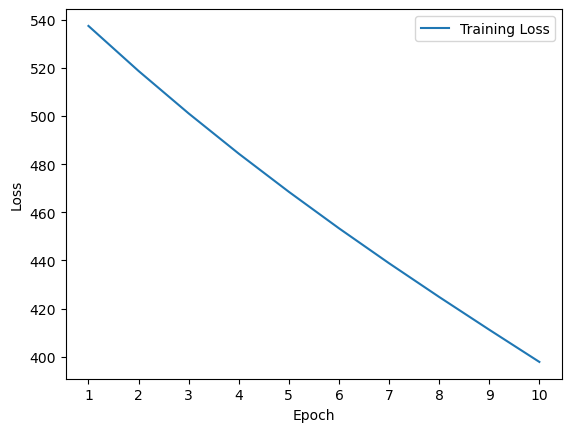

In [11]:
best_validation_accuracy = 0.0
best_model = None
best_optimizer = None
m = RunManager()
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()

start_whole_run = time.time()
total_parameters = len(b)
total_parameters_trained = 0
Epoch_num = []
ETA_list = []
Accuracy_list = []
Loss_list = []
learning_rate_list = []
Batch_size_list = []
days1 = 0
hours1 = 0
minutes1 = 0
seconds1 = 0
end_parameter_set = 0

for run in b:
	torch.cuda.empty_cache()
	total_parameters_trained += 1
	print(f"Running hyper parameters set:{run}")
	train_dataloader = torch.utils.data.DataLoader(siamese_dataset, batch_size=run.batch_size, shuffle=True)
	validation_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=run.batch_size, shuffle=False)
	model = SiameseNetwork()
	model = model.cuda()
	optimizer = run.op(model.parameters(), lr=run.lr)
	pre_train_time = time.time()
	model, counter, loss_history, epoch_acc = train(model, train_dataloader, criterion, optimizer,
													device=torch.device("cuda:0"))
	post_train_time = time.time()
	total_time = post_train_time - pre_train_time
	accuracy, avg_loss = m.validate(model, validation_dataloader)
	Epoch_num.append(run.number_epochs)
	ETA_list.append(total_time)
	Accuracy_list.append(accuracy)
	Loss_list.append(avg_loss)
	Batch_size_list.append(run.batch_size)
	learning_rate_list.append(run.lr)
	if accuracy > best_validation_accuracy:
		best_validation_accuracy = accuracy
		best_model = model
		best_optimizer = optimizer
		filename = f"BestRun_lr{run.lr}_bs{run.batch_size}_epoch{run.number_epochs}_op{run.op}_acc{(best_validation_accuracy * 100):.0f}.pth"
		m.save_checkpoint(model, optimizer, run.number_epochs, filename=filename)
		print(run, "Is the new best run. ", f"Accuracy:{(best_validation_accuracy * 100):.2f}")

	end_parameter_set = time.time()

headers = ["Epoch Number", "ETA", "Accuracy", "Loss", "Learning Rate", "Batch Size"]
csv_path = "Optimisation data.csv"
rows = zip(Epoch_num, ETA_list, Accuracy_list, Loss_list, learning_rate_list, Batch_size_list)
with open(csv_path, "w", newline="") as file:
	writer = csv.writer(file)
	writer.writerow(headers)
print(",".join(headers))
for row in rows:
	print(",".join(map(str, row)))